# CNN training on IMAGEN data

#### Import necessary modules and select the GPU

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# dependencies and plotting
import os, sys, inspect
from glob import glob
import h5py
import matplotlib.pyplot as plt 
import numpy as np

# path
from pathlib import Path

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# sklearn functions
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# load functions from nitorch
sys.path.insert(1,"/ritter/roshan/workspace/nitorch/")
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, IntensityRescale 
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
# from nitorch.trainer import Trainer
from nitorch.metrics import binary_balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters
from nitorch.data import *

from CNNpipeline import *
from models import *

In [3]:
gpus = [0,1,2]
# check_gpu_status(gpus)

In [31]:
a = np.array([1, 2, 6, 4, 2, 3, 2])
_, c = np.unique(a, return_counts=True)


array([0.85714286, 0.57142857, 0.85714286, 0.85714286, 0.85714286])

### Prepare Dataset

In [32]:
import joblib
joblib.__version__

'0.17.0'

In [4]:
# Check the directory and file
DATA_DIR = "/ritter/share/data/IMAGEN/h5files/"
h5_file = "fullbrain-fu3-z2-bingel3u6-n*.h5"
h5_file_holdout = "fullbrain-fu3-hold-z2-bingel3u6-n*.h5"

data = h5py.File(glob(DATA_DIR+h5_file)[0], 'r')
label = data.attrs['labels'][0] #'sex'
X_dataset = np.array(data['X'])
y_dataset = np.array(data[label]) 

data_hold = h5py.File(glob(DATA_DIR+h5_file_holdout)[0], 'r')
X_test = np.array(data_hold['X'])
y_test = np.array(data_hold[label]) 

##### Split the data

In [11]:
# test_size=20% and train_size=80% for total, training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_dataset, y_dataset, 
    test_size=0.20, stratify=y_dataset,
    random_state=42)

In [12]:
y_all = np.concatenate([y_train, y_val, y_test])
print(f'keys in h5_file: {[i for i in data.keys()]}')

df_size = pd.DataFrame({
    "all data":       {"total":len(y_all), "class0":np.sum(y_all), "class1":int(len(y_all)-np.sum(y_all))},
    "training set":   {"total":len(y_train), "class0":np.sum(y_train), "class1":int(len(y_train)-np.sum(y_train))},
    "validation set": {"total":len(y_val), "class0":np.sum(y_val), "class1":int(len(y_val)-np.sum(y_val))},
    "holdout set":    {"total":len(y_test), "class0":np.sum(y_test), "class1":int(len(y_test)-np.sum(y_test))},
}, dtype=int).T
display(df_size)

# Sanity checks
print(f"states of the label '{label}': {list(set(y_all))}")
print(f'examples of the label: {y_val[:5]}')

keys in h5_file: ['Binge', 'X', 'i', 'sex', 'site']


,total,class0,class1
all data,798,457,341
training set,556,318,238
validation set,140,80,60
holdout set,102,59,43


states of the label 'Binge': [0.0, 1.0]
examples of the label: [0. 1. 1. 0. 1.]


<b>Define Image Augmentations</b>

In [13]:
augmentations = [SagittalFlip(prob=0.5), SagittalTranslate(dist=(-2, 2)), IntensityRescale(masked=False)]
transform = transforms.Compose(augmentations + [ToTensor()])

In [15]:
IMAGEN_data_train = myDataset(X_train, y_train, transform=transform)
IMAGEN_data_val = myDataset(X_val, y_val, transform=transform)
IMAGEN_data_test = myDataset( X_test, y_test, transform=transform)

<b>Data Visualization</b>

In [1]:
# for i in [1,29,77, 99]:
#     sample = IMAGEN_data_train[i]
#     img = sample["image"].numpy()[0]
#     lbl = sample["label"].numpy()[0]
#     if lbl: 
#         print(f"AAM subject {i}")
#     else:
#         print(f"Control subject {i}")
# #     print("img shape =", img.shape, "value (max, mean, min)=", (img.max(), round(img.mean(),2), img.min()))
#     cut_coords = [43, 57, 45]

#     show_brain(img, cut_coords, cmap="gray", draw_cross=False)
#     plt.show()

### Prepare the model

In [11]:
# Instantiate our model, specify the use of CUDA with appropriate GPU 
# and check out the number of parameters using count_parameters imported from nitorch
net = SixtyFourNet().cuda(gpu)


NameError: name 'gpu' is not defined

### Training

In [15]:
output_dir = "results/imagen_fu3_pt"
if os.path.exists(output_dir) and (len(os.listdir(output_dir)) != 0): 
    print("[WARN]: files already exist in this directory. Move or delete them first.")

In [16]:
# Define the variables we want to pass into the model_fit function
trials=5
num_epochs=50
batch_size=8
# callback settings
earlystop_patience=8
ignore_epochs=earlystop_patience
retain_metric = binary_balanced_accuracy

debug=False
if debug:
    # only use 10 data points
    for data in IMAGEN_data_train, IMAGEN_data_val, IMAGEN_data_test:
        data.X = data.X[:10]
        data.y = data.y[:10]
    trials=1
    num_epochs=5
    batch_size=2
    earlystop_patience, ignore_epochs=2,0

In [17]:
metrics = [retain_metric]
callbacks = [
    EarlyStopping(earlystop_patience, ignore_before=ignore_epochs, 
                  retain_metric="loss", mode='min'), # dd: do early stopping on the loss instead of the metric
    ModelCheckpoint(path=output_dir, store_best=True, 
                    ignore_before=ignore_epochs, retain_metric=retain_metric)
]

-----------------------------------------
Starting trial 0
[0,    17] loss: 1.44150
[0,    34] loss: 1.11725
[0,    51] loss: 0.97316
[0,    68] loss: 0.91672
Time elapsed: 0h:0m:34s
train binary_balanced_accuracy: 56.87 %
val loss: 0.68346
val binary_balanced_accuracy: 50.00 %
[1,    17] loss: 0.68113
[1,    34] loss: 0.67649
[1,    51] loss: 0.67897
[1,    68] loss: 0.67992
Time elapsed: 0h:1m:10s
train binary_balanced_accuracy: 50.00 %
val loss: 0.68471
val binary_balanced_accuracy: 48.75 %
[2,    17] loss: 0.67524
[2,    34] loss: 0.67544
[2,    51] loss: 0.66844
[2,    68] loss: 0.67270
Time elapsed: 0h:2m:3s
train binary_balanced_accuracy: 54.76 %
val loss: 0.68717
val binary_balanced_accuracy: 53.75 %
[3,    17] loss: 0.67151
[3,    34] loss: 0.67549
[3,    51] loss: 0.67854
[3,    68] loss: 0.67432
Time elapsed: 0h:2m:40s
train binary_balanced_accuracy: 62.50 %
val loss: 0.68417
val binary_balanced_accuracy: 50.42 %
[4,    17] loss: 0.68761
[4,    34] loss: 0.66029
[4,    51] l

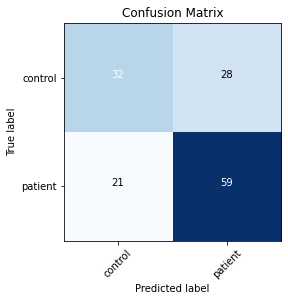

-----------------------------------------
Starting trial 1
[0,    17] loss: 1.12181
[0,    34] loss: 0.92359
[0,    51] loss: 0.83721
[0,    68] loss: 0.79944
Time elapsed: 0h:0m:35s
train binary_balanced_accuracy: 57.02 %
val loss: 0.68932
val binary_balanced_accuracy: 50.00 %
[1,    17] loss: 0.67144
[1,    34] loss: 0.68509
[1,    51] loss: 0.68821
[1,    68] loss: 0.68229
Time elapsed: 0h:1m:12s
train binary_balanced_accuracy: 50.00 %
val loss: 0.68888
val binary_balanced_accuracy: 50.42 %
[2,    17] loss: 0.68119
[2,    34] loss: 0.67163
[2,    51] loss: 0.67488
[2,    68] loss: 0.67265
Time elapsed: 0h:1m:50s
train binary_balanced_accuracy: 50.00 %
val loss: 0.69015
val binary_balanced_accuracy: 53.54 %


In [ ]:
# Call the model_fit function and print the mean and std of the metrics over all trials
best_metric, trial_metrics, models = train_n_times(
    network=SixtyFourNet, 
    train_data=IMAGEN_data_train, 
    val_data=IMAGEN_data_val,
    gpu=gpu,
    callbacks=callbacks,
    pretrained_model="results/pretrained_adni/trial_0_BEST_ITERATION.h5",
    metrics=metrics,
    trials=trials,
    b=batch_size,
    num_epochs=num_epochs,
    retain_metric=retain_metric,
    show_train_steps=None,
    show_validation_epochs=1,
    output_dir=output_dir)

In [28]:
trial_metrics=np.array(trial_metrics)
best_metric=np.array(best_metric)
print(f"Trial-wise scores: {np.round(trial_metrics*100, decimals=2)}%")
print(f"(mean"+u" \u00B1 "+f"std.dev) = ({np.round(np.mean(trial_metrics)*100, decimals=2)}%"+\
     u" \u00B1 "+ f"{np.round(np.std(trial_metrics)*100, decimals=2)})")
print(f"Trial-wise best scores: {np.round(best_metric*100, decimals=2)}%")
print(f"(mean"+u" \u00B1 "+f"std.dev) = ({np.round(np.mean(best_metric)*100, decimals=2)}%" + \
    u" \u00B1 " + f"{np.round(np.std(best_metric)*100, decimals=2)})")

Trial-wise scores: [61.46 65.62 63.54 70.42 74.79]%
(mean ± std.dev) = (67.17% ± 4.83)
Trial-wise best scores: [71.04 71.46 71.88 71.88 74.79]%
(mean ± std.dev) = (72.21% ± 1.33)


### Start inference

#### Using best model checkpoint for inference

Now that we have saved the models from each trial, we can load them and evaluate their performance on the test set.

In [23]:
test_loader = DataLoader(IMAGEN_data_test, batch_size=1, num_workers=1, shuffle=True)

trial 0
Balanced Accuracy: 0.7067402443831297
Specificity: 0.8372093023255814
Sensitivity: 0.576271186440678

trial 1
Balanced Accuracy: 0.7566022861647616
Specificity: 0.7674418604651163
Sensitivity: 0.7457627118644068

trial 2
Balanced Accuracy: 0.6834844304296412
Specificity: 0.7906976744186046
Sensitivity: 0.576271186440678

trial 3
Balanced Accuracy: 0.7830114308238076
Specificity: 0.8372093023255814
Sensitivity: 0.7288135593220338

trial 4
Balanced Accuracy: 0.7396531336223886
Specificity: 0.7674418604651163
Sensitivity: 0.711864406779661

######## Final results ########
Binary balanced accuracy mean: 73.39 %
Specificity mean: 80.00 %
Sensitivity mean: 66.78 %


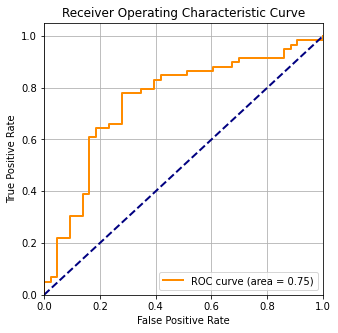

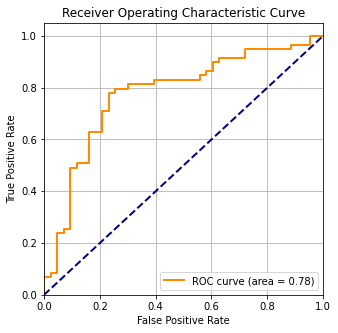

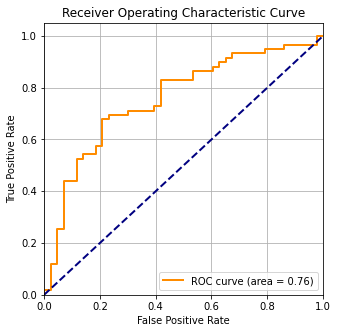

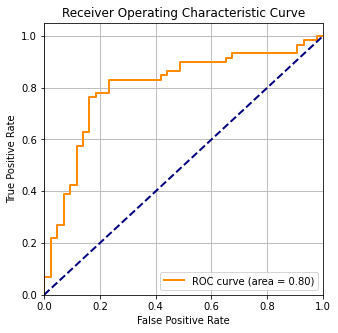

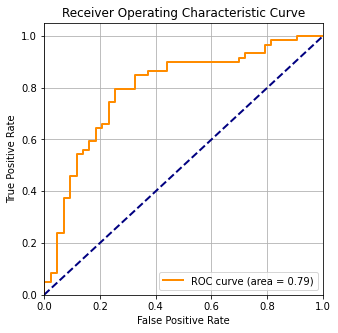

In [24]:
model_dirs = glob(output_dir+"/trial*-best.h5")
assert len(model_dirs) == trials
evaluate_models(test_loader, model_dirs, SixtyFourNet, 
                gpu=gpu, output_dir=output_dir)